In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from sklearn.model_selection import train_test_split
from keras.utils import Sequence

from tensorflow import keras
from tensorflow.keras.layers import Input, Conv3D, MaxPool3D, GlobalAveragePooling3D, Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import plot_model
from keras.metrics import AUC, F1Score
from sklearn.model_selection import train_test_split
from tensorflow.keras import mixed_precision 
from tensorflow.keras.regularizers import l2

In [2]:
def count_directories(path):
    # List all items in the directory and filter for directories
    return len([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])


path = "/kaggle/input/CT_Data/CT-23"
path2 = "/kaggle/input/CT_Data/CT-0"

print(f"Number of directories in non healthy: {count_directories(path2)}")
print(f"Number of directories in healthy: {count_directories(path)}")

Number of directories in non healthy: 100
Number of directories in healthy: 100


In [3]:
# Function to load a .nii.gz file
def load_nii(file_path):
    return nib.load(file_path).get_fdata()

class MultiModalDataset(Sequence):
    def __init__(self, patient_dirs, labels, batch_size, shuffle=True):
        self.patient_dirs = patient_dirs
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.patient_dirs))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.patient_dirs) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_patient_dirs = [self.patient_dirs[i] for i in batch_indices]
        batch_labels = [self.labels[i] for i in batch_indices]
        
        # Load modalities
        X = self.__load_modalities(batch_patient_dirs)
        y = np.array(batch_labels)

        X = tuple(tf.convert_to_tensor(x, dtype=tf.float32) for x in X)
        
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __load_modalities(self, patient_dirs):
        modalities = {'original': [], 'rotated': [], 'contrast': []}
        
        for patient_dir in patient_dirs:
            patient_name = os.path.basename(patient_dir)
        
            original_path = os.path.join(patient_dir, f'{patient_name}_original.nii')
            rotated_path = os.path.join(patient_dir, f'{patient_name}_rotated.nii')
            contrast_path = os.path.join(patient_dir, f'{patient_name}_contrast.nii')
            
            # Load each modality
            original = load_nii(original_path)
            rotated = load_nii(rotated_path)
            contrast = load_nii(contrast_path)
            
            # Append to the list for the batch
            modalities['original'].append(original)
            modalities['rotated'].append(rotated)
            modalities['contrast'].append(contrast)
        # Stack the modalities for each patient along the first axis (batch axis)
        X = [
            np.array(modalities['original']),
            np.array(modalities['rotated']),
            np.array(modalities['contrast'])
        ]
        
        return X

# Define the paths to your directories
healthy_dir = '/kaggle/input/CT_Data/CT-0'
non_healthy_dir = '/kaggle/input/CT_Data/CT-23'

# List all patient directories (assuming each patient has a folder in each group)
healthy_patients = [os.path.join(healthy_dir, f) for f in os.listdir(healthy_dir) if os.path.isdir(os.path.join(healthy_dir, f))]
non_healthy_patients = [os.path.join(non_healthy_dir, f) for f in os.listdir(non_healthy_dir) if os.path.isdir(os.path.join(non_healthy_dir, f))]

# Initialize lists to hold the data and labels
patient_dirs = []  # Will hold paths to the patient directories
labels = []  # Will hold the labels (0 for healthy, 1 for non-healthy)

# Load the data from healthy patients
for patient in healthy_patients:
    patient_dirs.append(patient)
    labels.append(0)  # Label 0 for healthy

# Load the data from non-healthy patients
for patient in non_healthy_patients:
    patient_dirs.append(patient)
    labels.append(1)  # Label 1 for non-healthy

# Convert to NumPy arrays
patient_dirs = np.array(patient_dirs)
labels = np.array(labels)

# Shuffle the data
indices = np.arange(len(patient_dirs))
np.random.shuffle(indices)

patient_dirs = patient_dirs[indices]
labels = labels[indices]

# Split the data into training and testing sets (80/20)
patient_dirs_train, patient_dirs_test, labels_train, labels_test = train_test_split(patient_dirs, labels, test_size=0.2, random_state=42)

# Create the training and testing dataset objects
train_dataset = MultiModalDataset(patient_dirs_train, labels_train, batch_size=3, shuffle=True)
test_dataset = MultiModalDataset(patient_dirs_test, labels_test, batch_size=3, shuffle=False)

# Check the length of the datasets
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Test Dataset Length: {len(test_dataset)}")
print(f"Labels Dataset Length: {len(labels)}")

print("\n")

X, y = train_dataset[0]

for modality, data in zip(['original', 'rotated', 'zoom'], X):
    print(f"Shape of {modality} modality: {data.shape}")
    
print(f"label: {y}")


Train Dataset Length: 53
Test Dataset Length: 13
Labels Dataset Length: 200


Shape of original modality: (3, 128, 128, 64)
Shape of rotated modality: (3, 128, 128, 64)
Shape of zoom modality: (3, 128, 128, 64)
label: [0 0 1]


Number of scans: 3
Dimension of CT scan: (128, 128, 64)
label= 0




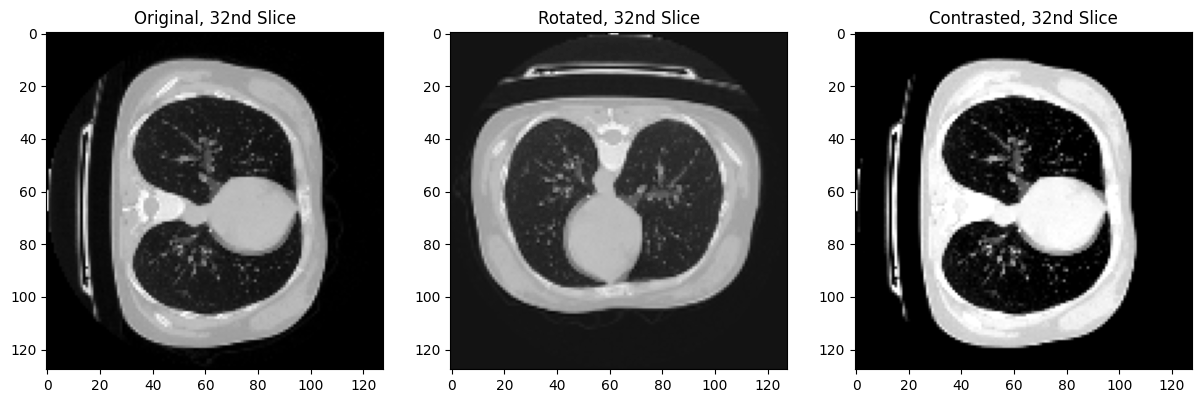

In [4]:
fig = plt.figure(figsize=(20,8))


for i in range(1):
    scans, label = train_dataset[i]
    print("Number of scans:", len(scans))
    print("Dimension of CT scan:", scans[0][0].shape)
    print("label=",label[i])
    print("\n")
    
    ax1 = plt.subplot(1,4,1)
    ax1.imshow(scans[0][0][:,:,32], cmap="gray")
    ax1.set_title("Original, 32nd Slice")
    ax2 = plt.subplot(1,4,2)
    ax2.imshow(scans[1][0][:,:,32], cmap="gray")
    ax2.set_title("Rotated, 32nd Slice")
    ax3 = plt.subplot(1,4,3)
    ax3.imshow(scans[2][0][:,:,32], cmap="gray")
    ax3.set_title("Contrasted, 32nd Slice")

In [10]:
def get_model(inputs):
    """Build a 3D convolutional neural network model."""
     
    x = Conv3D(filters=32, kernel_size=3, activation="relu", kernel_regularizer=l2(0.01), padding="same")(inputs)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=l2(0.01), padding="same")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=l2(0.01), padding="same")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=128, kernel_size=3, activation="relu", kernel_regularizer=l2(0.01), padding="same")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=128, kernel_size=3, activation="relu", kernel_regularizer=l2(0.01), padding="same")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    return x

In [11]:
original_input = Input(shape=(128, 128, 64, 1))
original_model = get_model(original_input)

rotated_input = Input(shape=(128, 128, 64, 1))
rotated_model = get_model(rotated_input)

contrast_input = Input(shape=(128, 128, 64, 1))
contrast_model = get_model(contrast_input)


# Concat models and add final block
x = concatenate([original_model, rotated_model, contrast_model])

x = GlobalAveragePooling3D()(x)
x = Dense(units=512, activation="relu")(x)
x = Dropout(0.3)(x)

output_layer = Dense(units=1, activation="sigmoid")(x)

# Final model
cnn_model = Model(inputs=[original_input, 
                          rotated_input, 
                          contrast_input], 
                  outputs=[output_layer],
                  name="multi3dcnn")

# f1score = tf.keras.metrics.F1Score(average="weighted",threshold=0.5)

initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

early_stop = EarlyStopping(monitor = 'val_accuracy', 
                           patience = 10, mode = 'min', verbose = 1,
                           restore_best_weights = True)

model_save = ModelCheckpoint(f'3d_image_classification.keras', 
                             save_best_only = True, 
                             monitor = 'val_accuracy', 
                             mode = 'min', verbose = 1)

# Compile final model
cnn_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                  metrics=["accuracy", "AUC", "Precision", "Recall"])

In [12]:
cnn_model.summary()

Model: "multi3dcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 64,   │              0 │ -                      │
│ (InputLayer)              │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 128, 128, 64,   │              0 │ -                      │
│ (InputLayer)              │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 128, 128, 64,   │              0 │ -                      │
│ (InputLayer)              │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 128, 128, 64,   │              0 │ input_layer_3[0][0]    │
│                           │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_1 (Cast)             │ (None, 128, 128, 64,   │              0 │ input_layer_4[0][0]    │
│                           │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_2 (Cast)             │ (None, 128, 128, 64,   │              0 │ input_layer_5[0][0]    │
│                           │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_15 (Conv3D)        │ (None, 128, 128, 64,   │            896 │ cast[0][0]             │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_20 (Conv3D)        │ (None, 128, 128, 64,   │            896 │ cast_1[0][0]           │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_25 (Conv3D)        │ (None, 128, 128, 64,   │            896 │ cast_2[0][0]           │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_15          │ (None, 64, 64, 32, 32) │              0 │ conv3d_15[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_20          │ (None, 64, 64, 32, 32) │              0 │ conv3d_20[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_25          │ (None, 64, 64, 32, 32) │              0 │ conv3d_25[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 64, 64, 32, 32) │            128 │ max_pooling3d_15[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 2,694,785 (10.28 MB)

 Trainable params: 2,692,289 (10.27 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [13]:
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
history = cnn_model.fit(train_dataset, validation_data=test_dataset, epochs=80, callbacks=[model_save, early_stop])

Epoch 1/80
